In [1]:
from random import random
import numpy as np
import mpmath as mp
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
from sympy import symbols, exp, laplace_transform, inverse_laplace_transform, solve
from scipy.integrate import quad
from scipy.optimize import root_scalar
import heapq
import torch
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep", n_colors=13)
np.random.seed(77)

In [2]:
def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_from_he(m, a, n):
    p = 1.0 / np.power(np.arange(1, m + 1), a)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap)
    trace = np.empty(n, dtype=np.int32)
    for idx in range(n):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_from_ph(alphas, Ts, length): # slower than gen_from_2ph, but general
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    n, m = A.shape
    A = A / A.sum(axis=1, keepdims=True)
    A_cdf = np.cumsum(A, axis=1)
    A_cdf[:, -1] = 1.0
    one = np.ones(m, np.float64)
    mu = -(T @ one)
    off = T.copy()
    idx = np.arange(m)
    off[:, idx, idx] = 0.0
    rdiag = -np.diagonal(T, axis1=1, axis2=2)
    jump = np.concatenate((off, mu[..., None]), axis=2) / rdiag[..., None]
    jump_cdf = np.cumsum(jump, axis=2)
    jump_cdf[:, :, -1] = 1.0
    def ph_time(k):
        s = np.searchsorted(A_cdf[k], np.random.random(), side="right")
        t = 0.0
        while 1:
            rate = rdiag[k, s]
            t += np.random.exponential(1.0 / rate)
            nxt = np.searchsorted(jump_cdf[k, s], np.random.random(), side="right")
            if nxt == m: return t
            s = nxt
    h = [(ph_time(i), i) for i in range(n)]
    heapq.heapify(h)
    trc = np.empty(length, np.int32)
    for t_idx in range(length):
        ct, i = h[0]
        trc[t_idx] = i + 1
        heapq.heapreplace(h, (ct + ph_time(i), i))
    return trc

def gen_from_2ph(n, theta, length, mu_ratio=10.0):
    n = int(n)
    length = int(length)
    p = np.arange(1, n + 1, dtype=np.float64)
    p = np.power(p, -float(theta))
    p /= p.sum()
    mr = float(mu_ratio)
    t0 = 0.5 * (mr + 1.0)
    t1 = 0.5 * (1.0 + 1.0 / mr)
    inv_rate0 = 1.0 / (t0 * p)
    inv_rate1 = 1.0 / (t1 * p)
    init_phase1 = (np.random.random(n) >= 0.5)
    init_scales = np.where(init_phase1, inv_rate1, inv_rate0)
    next_times = np.random.exponential(init_scales)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)
    trace = np.empty(length, dtype=np.int32)
    rand = np.random.random
    exp = np.random.exponential
    hreplace = heapq.heapreplace
    for idx in range(length):
        ctime, item = heap[0]
        trace[idx] = item + 1
        scale = inv_rate1[item] if rand() >= 0.5 else inv_rate0[item]
        hreplace(heap, (ctime + exp(scale), item))
    return trace
    
def gen_taus(tau_max, N, power=0.8):
    # Uniform grid in [0,1] raised to 'power' >1 compresses values toward 0
    return tau_max * (np.linspace(0.1, 1, N) ** power)

In [ ]:
# def _p_tauc(hi, tail=1e-14, ncap=200000):
#     p0 = np.exp(-hi)
#     if p0 == 0.0:
#         p0 = np.finfo(np.float64).tiny
#     pmf = [p0]
#     s = p0
#     n = 0
#     while 1.0 - s > tail and n < ncap:
#         n += 1
#         pmf.append(pmf[-1] * hi / n)
#         s += pmf[-1]
#     return np.asarray(pmf, np.float64), max(0.0, 1.0 - s)
import math
def _p_tauc(hi, tail=1e-14, ncap=200000):
    hi = float(hi)
    if hi <= 0.0:
        return np.array([1.0], dtype=np.float64), 0.0
    k0 = int(math.floor(hi))
    if k0 < 0:
        k0 = 0
    logp0 = -hi + k0 * math.log(hi) - math.lgamma(k0 + 1.0)
    pk0 = math.exp(logp0)
    pmf = np.zeros(k0 + 1, dtype=np.float64)
    pmf[k0] = pk0
    if hi != 0.0:
        for k in range(k0, 0, -1):
            pmf[k - 1] = pmf[k] * (k / hi)
    s = float(pmf.sum())
    kmax = k0
    pk = pmf[k0]
    while kmax < ncap:
        k1 = kmax + 1
        pk1 = pk * (hi / k1)
        pmf = np.append(pmf, pk1)
        s += float(pk1)
        kmax = k1
        pk = pk1
        if kmax + 2 > hi:
            r = hi / (kmax + 2.0)
            if r < 1.0:
                upper_tail_bound = pk * (r / (1.0 - r))  # sum_{j>=1} pk*r^j
                if upper_tail_bound <= tail:
                    break
        if 1.0 - s <= tail:
            break
    tail_mass = max(0.0, 1.0 - float(pmf.sum()))
    return pmf.astype(np.float64, copy=False), tail_mass

def clock_k_irm_linear(lmb, tc, K, tail=1e-14):
    lam = np.asarray(lmb, np.float64).ravel()
    lam /= lam.sum()
    tc = float(tc)
    K = int(K)
    M = lam.size
    if K == 0:
        pm = float(np.sum(lam / (1.0 + lam * tc)))
        C = int(round(tc * pm))
        return C, 1.0 - pm
    T = np.zeros(M, np.float64)
    one = np.ones(K, np.float64)
    I = np.eye(K, dtype=np.float64)
    for i, li in enumerate(lam):
        x = float(li * tc)
        pmf, tail_mass = _p_tauc(x, tail=tail)
        Q = np.zeros((K, K), np.float64)
        for s in range(K):
            for n, p in enumerate(pmf):
                if s == 0 and n == 0:
                    continue
                lvl = s + n
                nxt = (K - 1) if lvl >= K else max(lvl - 1, 0)
                Q[s, nxt] += p
            if tail_mass:
                Q[s, K - 1] += tail_mass
        A = I - Q
        try:
            t = np.linalg.solve(A, one)
        except np.linalg.LinAlgError:
            eps = np.finfo(np.float64).eps
            t = np.linalg.lstsq(A + eps * I, one, rcond=None)[0]
        T[i] = t[0]
    x = lam * tc
    pm_i = 1.0 / (1.0 + x * T)
    pm = float(np.sum(lam * pm_i))
    occ = float(np.sum(lam * pm_i * T))
    C = int(round(tc * occ))
    return C, 1.0 - pm

def _g_tauc(P, x, tail=1e-14, ncap=200000):
    pmf, tail_mass = _p_tauc(x, tail=tail, ncap=ncap)
    d = P.shape[0]
    I = np.eye(d, dtype=np.float64)
    Pn = I.copy()
    Sn = np.zeros((d, d), np.float64)
    Pmix = np.zeros((d, d), np.float64)
    Smix = np.zeros((d, d), np.float64)
    for _, w in enumerate(pmf):
        if w:
            Pmix += w * Pn
            Smix += w * Sn
        Sn = Sn + Pn
        Pn = Pn @ P
    if tail_mass:
        Pmix += tail_mass * Pn
        Smix += tail_mass * Sn
    return Pmix, Smix

def clock_k_ph_linear(alphas, Ts, tc, K, tail=1e-14, ncap=200000):
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    n, m = A.shape
    A = A / A.sum(axis=1, keepdims=True)
    tc = float(tc)
    K = int(K)
    one = np.ones(m, np.float64)
    mean_iat = np.empty(n, np.float64)
    for i in range(n):
        mean_iat[i] = float(A[i] @ np.linalg.solve(-T[i], one))
    lam = 1.0 / mean_iat
    w = lam / lam.sum()
    pm = 0.0
    occ = 0.0
    for i in range(n):
        a = A[i]
        Ti = T[i]
        qi = float(np.max(-np.diag(Ti)))
        B = np.eye(m, dtype=np.float64) + Ti / qi
        eta = (-(Ti @ one)) / qi
        U = (eta[:, None] * a[None, :])
        if K == 0:
            Pph = B + U
            Ptc, Ssum = _g_tauc(Pph, qi * tc, tail=tail, ncap=ncap)
            rho0 = a
            m_tc = float(rho0 @ (Ssum @ eta))
            pm_i = 1.0 / (1.0 + m_tc)
            pm += w[i] * pm_i
            occ += w[i] * pm_i
            continue
        blocks = [[np.zeros((m, m), np.float64) for _ in range(K + 1)] for _ in range(K + 1)]
        for k in range(K):
            blocks[k][k] = B
            blocks[k][k + 1] = U
        blocks[K][K] = B + U
        P = np.block(blocks)
        Ptc, Ssum = _g_tauc(P, qi * tc, tail=tail, ncap=ncap)
        g = np.tile(eta, K + 1)
        Nh = K * m
        Q = Ptc[:Nh, m:(K + 1) * m]
        h = (Ssum @ g)[:Nh]
        nu = np.zeros(Nh, np.float64)
        nu[:m] = a
        x = np.linalg.solve((np.eye(Nh, dtype=np.float64) - Q).T, nu)
        Oi = float(x.sum())
        Hi = float(x @ h)
        pm_i = 1.0 / (1.0 + Hi)
        pm += w[i] * pm_i
        occ += w[i] * pm_i * Oi
    C = int(round(tc * occ))
    return C, 1.0 - float(pm)

def clock_k_he_linear(lmb, tc, K):
    lam = np.asarray(lmb, dtype=np.float64).ravel()
    lam /= lam.sum()
    M = lam.size
    tc = int(tc)
    K = int(K)
    B = np.diag(1.0 - lam)
    U = lam[:, None] * lam[None, :] 
    Pph = B + U
    if K == 0:
        rho = lam.copy()
        m_tc = 0.0
        for _ in range(tc):
            m_tc += float(rho @ lam)
            rho = rho @ Pph
        pm = 1.0 / (1.0 + m_tc)   
        C = int(round(tc * pm))
        return C, 1.0 - pm
    N = (K + 1) * M
    blocks = [[np.zeros((M, M), dtype=np.float64) for _ in range(K + 1)] for _ in range(K + 1)]
    for k in range(K):
        blocks[k][k] = B
        blocks[k][k + 1] = U
    blocks[K][K] = B + U
    P = np.block(blocks)
    def _pow_sum(A, n):
        I = np.eye(A.shape[0], dtype=A.dtype)
        if n == 0:
            return I, np.zeros_like(A)
        if n == 1:
            return A, I
        if n % 2 == 0:
            A2, S2 = _pow_sum(A, n // 2)
            return A2 @ A2, S2 + A2 @ S2
        Am, Sm = _pow_sum(A, n - 1)
        return Am @ A, Sm + Am
    Ptc, Ssum = _pow_sum(P, tc)
    g = np.tile(lam, K + 1)
    Nh = K * M
    head = slice(0, Nh)
    tail = slice(M, (K + 1) * M)
    Q = Ptc[head, tail]
    h = (Ssum @ g)[head]
    nu = np.zeros(Nh, dtype=np.float64)
    nu[:M] = lam
    x = np.linalg.solve((np.eye(Nh, dtype=np.float64) - Q).T, nu)
    O = float(x.sum())
    H = float(x @ h)
    pm = 1.0 / (1.0 + H)
    C = int(round(tc * O * pm))
    return C, 1.0 - pm

In [7]:
import time

m = 240
n = 10000000
a = 0.8
mu_ratio = 10.0
mu2 = (1.0 / mu_ratio + 1.0) / 2.0
mu1 = mu_ratio * mu2
T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=np.float64)
alphas_ph = np.array([np.array([1/2, 1/2]) for _ in range(m)])
# p, _ = gen_from_zipf(m, n, a)
Ts_ph = np.array([p[i]*T for i in range(m)], dtype=np.float64)   

taus = gen_taus(m * 1.5, 10, power=0.95)
for tc in taus:
    s = time.time()
    c_cc_ph_pred, hr_cc_ph_pred = clock_k_ph_linear(alphas_ph, Ts_ph, tc, K=15)
    e = time.time()
    print(f"Linear solve ph took {e-s:.2f} seconds")
    hr_sim= tg.sim_clock(int(c_cc_ph_pred), trc_ph2, raw=True, K=15)
    print(f"c_ph_pred={c_cc_ph_pred}, hr_ph_pred={hr_cc_ph_pred}, hr_sim={hr_sim}")
    print("----")

Linear solve ph took 0.10 seconds
c_ph_pred=35, hr_ph_pred=0.5766372034137434, hr_sim=0.5727511000000001
----
Linear solve ph took 0.10 seconds
c_ph_pred=61, hr_ph_pred=0.707830042004187, hr_sim=0.7055985
----
Linear solve ph took 0.11 seconds
c_ph_pred=83, hr_ph_pred=0.7799924056167385, hr_sim=0.7789714
----
Linear solve ph took 0.11 seconds
c_ph_pred=102, hr_ph_pred=0.827023231709098, hr_sim=0.826496
----
Linear solve ph took 0.10 seconds
c_ph_pred=118, hr_ph_pred=0.8604805734418153, hr_sim=0.8588842
----
Linear solve ph took 0.10 seconds
c_ph_pred=133, hr_ph_pred=0.8856686193992438, hr_sim=0.8845775
----
Linear solve ph took 0.11 seconds
c_ph_pred=147, hr_ph_pred=0.9053970377519631, hr_sim=0.905514
----
Linear solve ph took 0.11 seconds
c_ph_pred=158, hr_ph_pred=0.921292864904976, hr_sim=0.920179
----
Linear solve ph took 0.11 seconds
c_ph_pred=169, hr_ph_pred=0.9343626431185844, hr_sim=0.933725
----
Linear solve ph took 0.11 seconds
c_ph_pred=179, hr_ph_pred=0.9452635699855951, hr_

In [ ]:
# use gen_from_2ph
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
thetas = [0.8, 1.1]
ks = [0, 1, 15]
mu_ratio = 10.0
mu2 = (1.0 / mu_ratio + 1.0) / 2.0
mu1 = mu_ratio * mu2
T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=np.float64) 
records, errors = [], []

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.85)
    alphas_ph = np.array([np.array([1/2, 1/2]) for _ in range(m)])
    for theta in thetas:
        lmb, trc_irm = gen_from_zipf(m, n, theta)
        Ts_ph = np.array([lmb[i]*T for i in range(m)], dtype=np.float64)
        trc_ph = gen_from_2ph(m, theta, n, mu_ratio=mu_ratio)
        for tc in taus:
            for k in ks:
                c_cc_irm_pred, hr_cc_irm_pred = clock_k_irm_linear(lmb, tc, k)
                if k == 0:
                    hr_sim_irm = tg.sim_fifo(int(c_cc_irm_pred), trc_irm, raw=True)
                else:
                    hr_sim_irm = tg.sim_clock(int(c_cc_irm_pred), trc_irm, raw=True, K=k)
                c_cc_ph_pred, hr_cc_ph_pred = clock_k_ph_linear(alphas_ph, Ts_ph, tc, K=k)
                if k == 0:
                    hr_sim_ph = tg.sim_fifo(int(c_cc_ph_pred), trc_ph, raw=True)
                else:
                    hr_sim_ph = tg.sim_clock(int(c_cc_ph_pred), trc_ph, raw=True, K=k)
                records.append((m, theta, tc, k, c_cc_irm_pred, hr_cc_irm_pred, hr_sim_irm, c_cc_ph_pred, hr_cc_ph_pred, hr_sim_ph))
                errors.append((m, theta, tc, k,
                               abs(hr_cc_irm_pred - hr_sim_irm) / hr_sim_irm,
                               abs(hr_cc_ph_pred - hr_sim_ph) / hr_sim_ph))
df_records = pd.DataFrame(records, columns=["m", "theta", "tc", "k", "c_cc_irm_pred", "hr_cc_irm_pred", "hr_sim_irm", "c_cc_ph_pred", "hr_cc_ph_pred", "hr_sim_ph"])
df_errors = pd.DataFrame(errors, columns=["m", "theta", "tc", "k", "rel_error_irm", "rel_error_ph"])

In [50]:
df_records.to_pickle("ttl_clock_k_records.pkl")
df_errors.to_pickle("ttl_clock_k_errors.pkl")

df_records = pd.read_pickle("ttl_clock_k_records.pkl")
df_errors = pd.read_pickle("ttl_clock_k_errors.pkl")

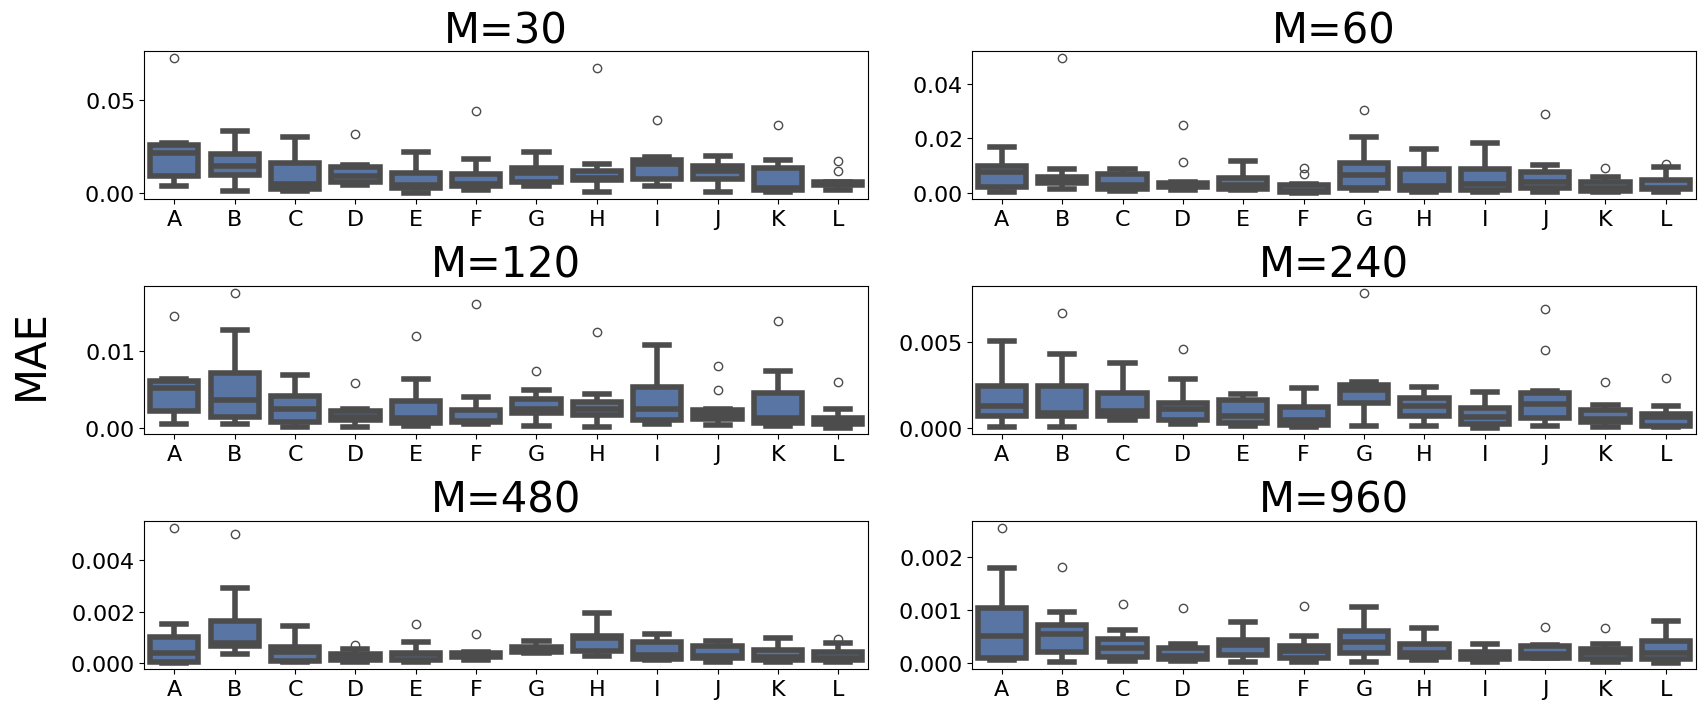

In [49]:
workloads = ["IRM", "PH"]
pairs = list(itertools.product(workloads, ks, thetas))
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(pairs)])

sns.set_palette("deep")
font_axes = 30
font_ticks = 16
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = pd.concat([
    df_errors[["m", "theta", "tc", "k", "rel_error_irm"]]
        .rename(columns={"rel_error_irm": "abs_error"})
        .assign(workload="IRM"),
    df_errors[["m", "theta", "tc", "k", "rel_error_ph"]]
        .rename(columns={"rel_error_ph": "abs_error"})
        .assign(workload="PH"),
], ignore_index=True)

df_plot["method_param"] = list(zip(df_plot.workload, df_plot.k, df_plot.theta))
df_plot["label"] = df_plot["method_param"].map(mapping)
df_plot = df_plot.dropna(subset=["label", "abs_error"]).copy()

ms = [30, 60, 120, 240, 480, 960]
subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, M in zip(axes_flat, ms):
    cell = df_plot[df_plot.m == M].copy()
    sns.boxplot(x='label', y='abs_error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("figures/clock_k_mae.pdf", format='pdf')
plt.show()


In [ ]:
# use gen_from_he
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
thetas = [0.8, 1.1]
records = []
errors = []
ks = [0, 1, 15]

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.95)
    for a in thetas:
        lmb, trc_irm = gen_from_zipf(m, n, a)
        trc_he = gen_from_he(m, a, n)      

        for tc in taus:
            for k in ks:
                cc_c_irm_pred, cc_hr_irm_pred = clock_k_irm_linear(lmb, tc, K=k)
                if k == 0:
                    cc_hr_irm_sim = tg.sim_fifo(int(cc_c_irm_pred), trc_irm, raw=True)
                else:
                    cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred), trc_irm, raw=True, K=k)

                cc_c_he_pred, cc_hr_he_pred = clock_k_he_linear(lmb, tc, K=k)
                if k == 0:
                    cc_hr_he_sim = tg.sim_fifo(int(cc_c_he_pred), trc_he, raw=True)
                else:
                    cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred), trc_he, raw=True, K=k)

                records.append((m, a, tc, k, cc_c_irm_pred, cc_hr_irm_pred, cc_hr_irm_sim, cc_c_he_pred, cc_hr_he_pred, cc_hr_he_sim))
                errors.append((m, a, tc, k,
                               abs(cc_hr_irm_pred - cc_hr_irm_sim) / cc_hr_irm_sim,
                               abs(cc_hr_he_pred - cc_hr_he_sim) / cc_hr_he_sim))
df_records = pd.DataFrame(records, columns=["m", "theta", "tc", "k", "c_cc_irm_pred", "hr_cc_irm_pred", "hr_sim_irm", "c_cc_he_pred", "hr_cc_he_pred", "hr_sim_he"])
df_errors = pd.DataFrame(errors, columns=["m", "theta", "tc", "k", "rel_error_irm", "rel_error_he"])

In [16]:
df_records.to_pickle("ttl_clock_k2_records.pkl")
df_errors.to_pickle("ttl_clock_k2_errors.pkl")

df_records = pd.read_pickle("ttl_clock_k2_records.pkl")
df_errors = pd.read_pickle("ttl_clock_k2_errors.pkl")

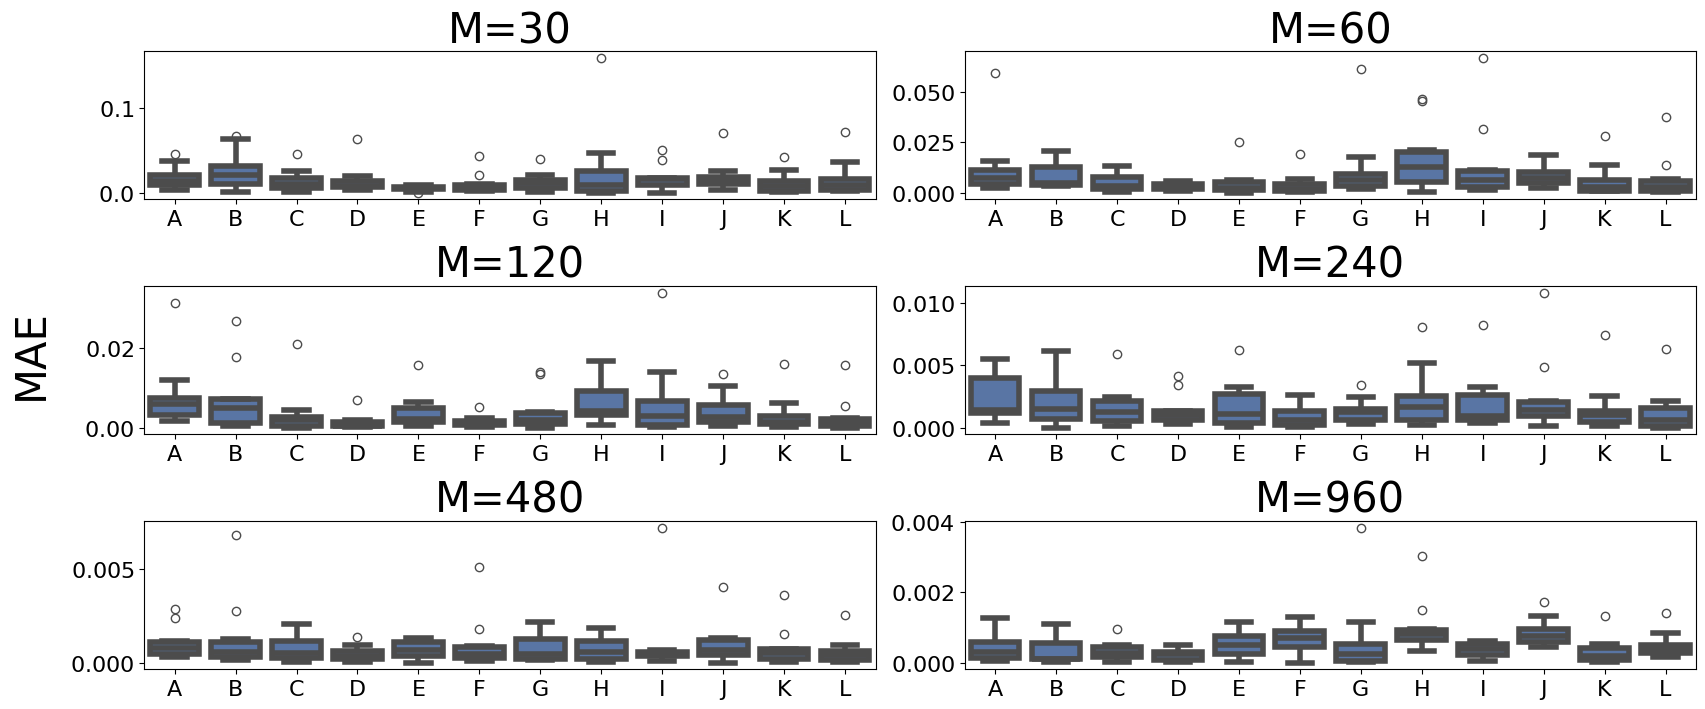

In [17]:
workloads = ["IRM", "HE"]
pairs = list(itertools.product(workloads, ks, thetas))
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(pairs)])

sns.set_palette("deep")
font_axes = 30
font_ticks = 16
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = pd.concat([
    df_errors[["m", "theta", "tc", "k", "rel_error_irm"]]
        .rename(columns={"rel_error_irm": "abs_error"})
        .assign(workload="IRM"),
    df_errors[["m", "theta", "tc", "k", "rel_error_he"]]
        .rename(columns={"rel_error_he": "abs_error"})
        .assign(workload="HE"),
], ignore_index=True)

df_plot["method_param"] = list(zip(df_plot.workload, df_plot.k, df_plot.theta))
df_plot["label"] = df_plot["method_param"].map(mapping)
df_plot = df_plot.dropna(subset=["label", "abs_error"]).copy()

ms = [30, 60, 120, 240, 480, 960]
subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, M in zip(axes_flat, ms):
    cell = df_plot[df_plot.m == M].copy()
    sns.boxplot(x='label', y='abs_error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
# plt.savefig("figures/clock_k2_mae.pdf", format='pdf')
plt.show()


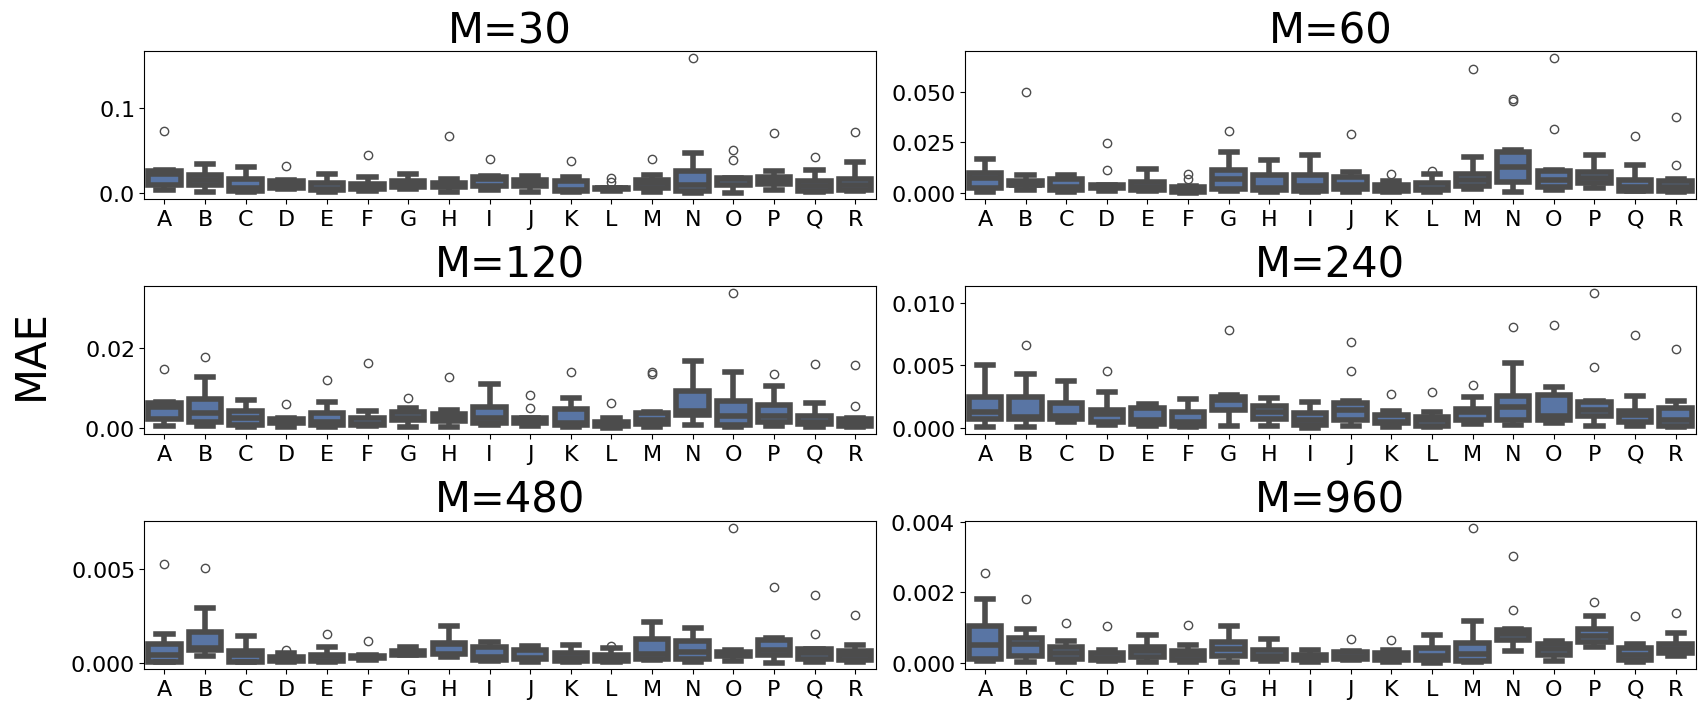

In [ ]:
# combined boxplot
df_err_irm_ph = pd.read_pickle("ttl_clock_k_errors.pkl")
df_err_irm_he = pd.read_pickle("ttl_clock_k2_errors.pkl")

thetas = [0.8, 1.1]
ks = [0, 1, 15]
workloads = ["IRM", "PH", "HE"]
pairs = list(itertools.product(workloads, ks, thetas))
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(pairs)])

sns.set_palette("deep")
font_axes = 30
font_ticks = 16
line_width = 4

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = pd.concat([
    df_err_irm_ph[["m", "theta", "tc", "k", "rel_error_irm"]]
        .rename(columns={"rel_error_irm": "abs_error"})
        .assign(workload="IRM"),
    df_err_irm_ph[["m", "theta", "tc", "k", "rel_error_ph"]]
        .rename(columns={"rel_error_ph": "abs_error"})
        .assign(workload="PH"),
    df_err_irm_he[["m", "theta", "tc", "k", "rel_error_he"]]
        .rename(columns={"rel_error_he": "abs_error"})
        .assign(workload="HE"),
], ignore_index=True)

df_plot["method_param"] = list(zip(df_plot.workload, df_plot.k, df_plot.theta))
df_plot["label"] = df_plot["method_param"].map(mapping)
df_plot = df_plot.dropna(subset=["label", "abs_error"]).copy()

ms = [30, 60, 120, 240, 480, 960]
subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, M in zip(axes_flat, ms):
    cell = df_plot[df_plot.m == M].copy()
    sns.boxplot(x="label", y="abs_error", data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

fig2.text(0.025, 0.5, "MAE", va="center", rotation="vertical",
          fontsize=font_axes)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("figures/clock_k_all_mae.pdf", format="pdf")
plt.show()


In [3]:
def sim_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_clock

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def p_vec(theta, n):
    ranks = np.arange(1, n + 1, dtype=float)
    p = 1.0 / np.power(ranks, theta)
    p /= p.sum()
    return np.cumsum(p)

def ub_dist(cache_sizes, hit_rates, p):
    cache_sizes = np.asarray(cache_sizes, dtype=int)
    ub = p[cache_sizes-1]
    dist = np.asarray(hit_rates) - ub
    return dist

p08 = p_vec(theta=0.8, n=120)
p11 = p_vec(theta=1.1, n=120)


In [ ]:
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
thetas = [0.8, 1.1]
ks = [0, 1, 15]
mu_ratio = 10.0
mu2 = (1.0 / mu_ratio + 1.0) / 2.0
mu1 = mu_ratio * mu2
T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=np.float64) 

In [4]:
# lmb08, irm_08 = gen_from_zipf(120, 10000000, 0.8)
# ph_08 = gen_from_2ph(120, 0.8, 10000000, mu_ratio=10.0)
# he_08 = gen_from_he(120, 0.8, 10000000)
irm_08 = np.loadtxt('traces/zipf_120_08_trace.txt', dtype=np.int32)
ph_08 = np.loadtxt('traces/ph_120_08_trace.txt', dtype=np.int32)
he_08 = np.loadtxt('traces/he_120_08_trace.txt', dtype=np.int32)
# lmb11, irm_11 = gen_from_zipf(120, 10000000, 1.1)
# ph_11 = gen_from_2ph(120, 1.1, 10000000, mu_ratio=10.0)
he_11 = gen_from_he(120, 1.1, 10000000)
np.savetxt('traces/he_120_11_trace.txt', he_11, fmt='%d')
irm_11 = np.loadtxt('traces/zipf_120_11_trace.txt', dtype=np.int32)
ph_11 = np.loadtxt('traces/ph_120_11_trace.txt', dtype=np.int32)
he_11 = np.loadtxt('traces/he_120_11_trace.txt', dtype=np.int32)


In [7]:
# # K = 0
# c_irm_08_k0, hr_irm_08_k0 = sim_fifo(irm_08)
# c_ph_08_k0, hr_ph_08_k0 = sim_fifo(ph_08)
# c_he_08_k0, hr_he_08_k0 = sim_fifo(he_08)

# # K = 1
# c_irm_08_k1, hr_irm_08_k1 = sim_clock(irm_08, cnt=1)
# c_ph_08_k1, hr_ph_08_k1 = sim_clock(ph_08, cnt=1)
# c_he_08_k1, hr_he_08_k1 = sim_clock(he_08, cnt=1)

# # K = 15
# c_irm_08_k15, hr_irm_08_k15 = sim_clock(irm_08, cnt=15)
# c_ph_08_k15, hr_ph_08_k15 = sim_clock(ph_08, cnt=15)
# c_he_08_k15, hr_he_08_k15 = sim_clock(he_08, cnt=15)

# np.savez_compressed('data/mrcs_irm_ph_he_08.npz',
#                     c_irm_08_k0=c_irm_08_k0, hr_irm_08_k0=hr_irm_08_k0,
#                     c_ph_08_k0=c_ph_08_k0, hr_ph_08_k0=hr_ph_08_k0,
#                     c_he_08_k0=c_he_08_k0, hr_he_08_k0=hr_he_08_k0,
#                     c_irm_08_k1=c_irm_08_k1, hr_irm_08_k1=hr_irm_08_k1,
#                     c_ph_08_k1=c_ph_08_k1, hr_ph_08_k1=hr_ph_08_k1,
#                     c_he_08_k1=c_he_08_k1, hr_he_08_k1=hr_he_08_k1,
#                     c_irm_08_k15=c_irm_08_k15, hr_irm_08_k15=hr_irm_08_k15,
#                     c_ph_08_k15=c_ph_08_k15, hr_ph_08_k15=hr_ph_08_k15,
#                     c_he_08_k15=c_he_08_k15, hr_he_08_k15=hr_he_08_k15)

# c_irm_11_k0, hr_irm_11_k0 = sim_fifo(irm_11)
# c_ph_11_k0, hr_ph_11_k0 = sim_fifo(ph_11)
# c_he_11_k0, hr_he_11_k0 = sim_fifo(he_11)
# c_irm_11_k1, hr_irm_11_k1 = sim_clock(irm_11, cnt=1)
# c_ph_11_k1, hr_ph_11_k1 = sim_clock(ph_11, cnt=1)
# c_he_11_k1, hr_he_11_k1 = sim_clock(he_11, cnt=1)
# c_irm_11_k15, hr_irm_11_k15 = sim_clock(irm_11, cnt=15)
# c_ph_11_k15, hr_ph_11_k15 = sim_clock(ph_11, cnt=15)
# c_he_11_k15, hr_he_11_k15 = sim_clock(he_11, cnt=15)

np.savez_compressed('data/mrcs_irm_ph_he_11.npz',
                    c_irm_11_k0=c_irm_11_k0, hr_irm_11_k0=hr_irm_11_k0,
                    c_ph_11_k0=c_ph_11_k0, hr_ph_11_k0=hr_ph_11_k0,
                    c_he_11_k0=c_he_11_k0, hr_he_11_k0=hr_he_11_k0,
                    c_irm_11_k1=c_irm_11_k1, hr_irm_11_k1=hr_irm_11_k1,
                    c_ph_11_k1=c_ph_11_k1, hr_ph_11_k1=hr_ph_11_k1,
                    c_he_11_k1=c_he_11_k1, hr_he_11_k1=hr_he_11_k1,
                    c_irm_11_k15=c_irm_11_k15, hr_irm_11_k15=hr_irm_11_k15,
                    c_ph_11_k15=c_ph_11_k15, hr_ph_11_k15=hr_ph_11_k15,
                    c_he_11_k15=c_he_11_k15, hr_he_11_k15=hr_he_11_k15)

In [8]:
c_irm_08_k0, hr_irm_08_k0, c_ph_08_k0, hr_ph_08_k0, c_he_08_k0, hr_he_08_k0, c_irm_08_k1, hr_irm_08_k1, c_ph_08_k1, hr_ph_08_k1, c_he_08_k1, hr_he_08_k1, c_irm_08_k15, hr_irm_08_k15, c_ph_08_k15, hr_ph_08_k15, c_he_08_k15, hr_he_08_k15 = np.load('data/mrcs_irm_ph_he_08.npz').values()
c_irm_11_k0, hr_irm_11_k0, c_ph_11_k0, hr_ph_11_k0, c_he_11_k0, hr_he_11_k0, c_irm_11_k1, hr_irm_11_k1, c_ph_11_k1, hr_ph_11_k1, c_he_11_k1, hr_he_11_k1, c_irm_11_k15, hr_irm_11_k15, c_ph_11_k15, hr_ph_11_k15, c_he_11_k15, hr_he_11_k15 = np.load('data/mrcs_irm_ph_he_11.npz').values()

In [9]:
base_styles = {
    'K=0': {palette[0], '^'},
    'K=1': {palette[1], 's'},
    'K=15': {palette[2], 'o'},
}

dist_irm_08 = {
    'K=0': ub_dist(c_irm_08_k0, hr_irm_08_k0, p08),
    'K=1': ub_dist(c_irm_08_k1, hr_irm_08_k1, p08),
    'K=15': ub_dist(c_irm_08_k15, hr_irm_08_k15, p08),
}

entries_irm_08 = []
for label, c_vals in [
    ('K=0', c_irm_08_k0),
    ('K=1', c_irm_08_k1),
    ('K=15', c_irm_08_k15),
]:
    color, marker = base_styles[label]
    linestyle = '-' if label == 'K=0' else '--' if label == 'K=1' else ':'
    entries_irm_08.append((label, color, marker, linestyle, c_vals))

dist_ph_08 = {
    'K=0': ub_dist(c_ph_08_k0, hr_ph_08_k0, p08),
    'K=1': ub_dist(c_ph_08_k1, hr_ph_08_k1, p08),
    'K=15': ub_dist(c_ph_08_k15, hr_ph_08_k15, p08),
}

entries_ph_08 = []
for label, c_vals in [
    ('K=0', c_ph_08_k0),
    ('K=1', c_ph_08_k1),
    ('K=15', c_ph_08_k15),
]:
    color, marker = base_styles[label]
    linestyle = '-' if label == 'K=0' else '--' if label == 'K=1' else ':'
    entries_ph_08.append((label, color, marker, linestyle, c_vals))

dist_he_08 = {
    'K=0': ub_dist(c_he_08_k0, hr_he_08_k0, p08),
    'K=1': ub_dist(c_he_08_k1, hr_he_08_k1, p08),
    'K=15': ub_dist(c_he_08_k15, hr_he_08_k15, p08),
}

entries_he_08 = []
for label, c_vals in [
    ('K=0', c_he_08_k0),
    ('K=1', c_he_08_k1),
    ('K=15', c_he_08_k15),
]:
    color, marker = base_styles[label]
    linestyle = '-' if label == 'K=0' else '--' if label == 'K=1' else ':'
    entries_he_08.append((label, color, marker, linestyle, c_vals))

dist_irm_11 = {
    'K=0': ub_dist(c_irm_11_k0, hr_irm_11_k0, p11),
    'K=1': ub_dist(c_irm_11_k1, hr_irm_11_k1, p11),
    'K=15': ub_dist(c_irm_11_k15, hr_irm_11_k15, p11),
}

entries_irm_11 = []
for label, c_vals in [
    ('K=0', c_irm_11_k0),
    ('K=1', c_irm_11_k1),
    ('K=15', c_irm_11_k15),
]:
    color, marker = base_styles[label]
    linestyle = '-' if label == 'K=0' else '--' if label == 'K=1' else ':'
    entries_irm_11.append((label, color, marker, linestyle, c_vals))

dist_ph_11 = {
    'K=0': ub_dist(c_ph_11_k0, hr_ph_11_k0, p11),
    'K=1': ub_dist(c_ph_11_k1, hr_ph_11_k1, p11),
    'K=15': ub_dist(c_ph_11_k15, hr_ph_11_k15, p11),
}

entries_ph_11 = []
for label, c_vals in [
    ('K=0', c_ph_11_k0),
    ('K=1', c_ph_11_k1),
    ('K=15', c_ph_11_k15),
]:
    color, marker = base_styles[label]
    linestyle = '-' if label == 'K=0' else '--' if label == 'K=1' else ':'
    entries_ph_11.append((label, color, marker, linestyle, c_vals))

dist_he_11 = {
    'K=0': ub_dist(c_he_11_k0, hr_he_11_k0, p11),
    'K=1': ub_dist(c_he_11_k1, hr_he_11_k1, p11),
    'K=15': ub_dist(c_he_11_k15, hr_he_11_k15, p11),
}

entries_he_11 = []
for label, c_vals in [
    ('K=0', c_he_11_k0),
    ('K=1', c_he_11_k1),
    ('K=15', c_he_11_k15),
]:
    color, marker = base_styles[label]
    linestyle = '-' if label == 'K=0' else '--' if label == 'K=1' else ':'
    entries_he_11.append((label, color, marker, linestyle, c_vals))

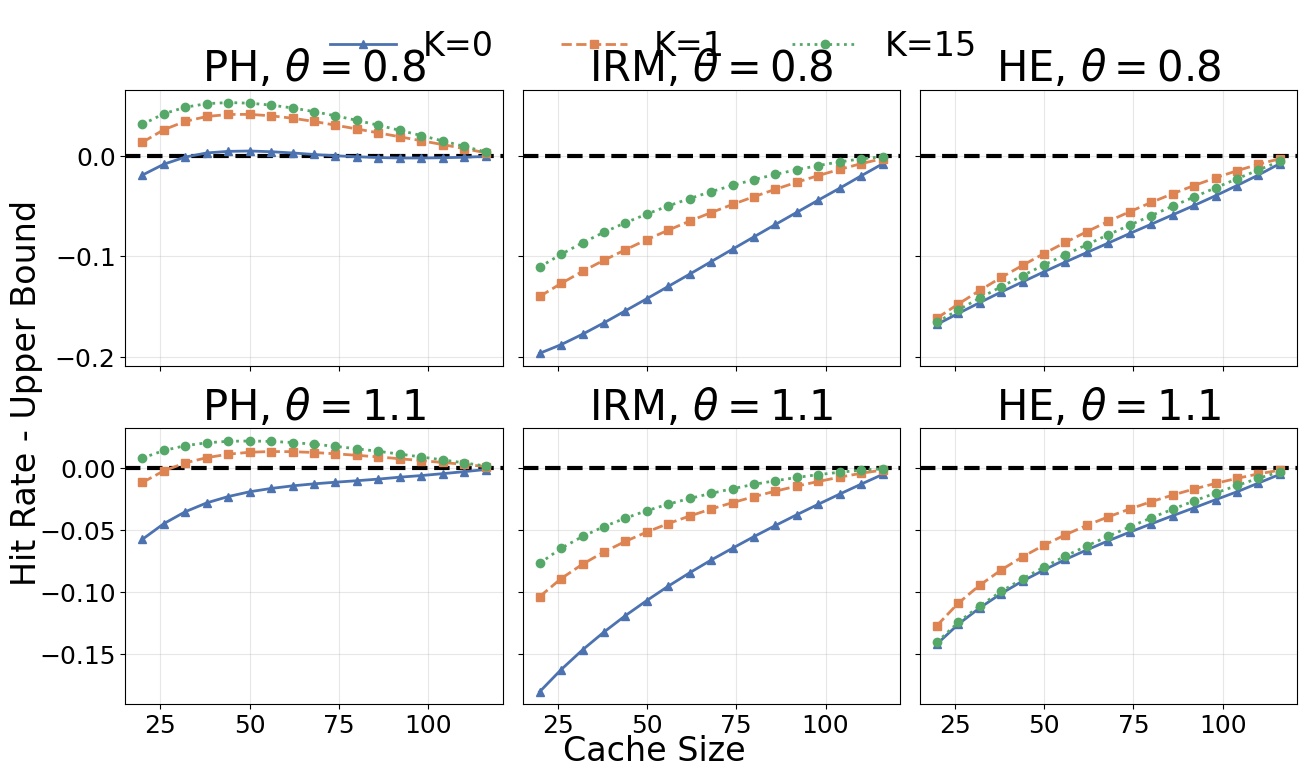

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey='row')
(ax_ph08_s, ax_irm08_s, ax_he08_s), (ax_ph11_s, ax_irm11_s, ax_he11_s) = axes

order_labels = ['K=0', 'K=1', 'K=15']

style_map = {
    'K=0': (palette[0], '^', '-'),
    'K=1': (palette[1], 's', '--'),
    'K=15': (palette[2], 'o', ':'),
}

series_lookup = {
    ('PH', 0.8): {
        'K=0': (c_ph_08_k0, dist_ph_08['K=0']),
        'K=1': (c_ph_08_k1, dist_ph_08['K=1']),
        'K=15': (c_ph_08_k15, dist_ph_08['K=15']),
    },
    ('IRM', 0.8): {
        'K=0': (c_irm_08_k0, dist_irm_08['K=0']),
        'K=1': (c_irm_08_k1, dist_irm_08['K=1']),
        'K=15': (c_irm_08_k15, dist_irm_08['K=15']),
    },
    ('HE', 0.8): {
        'K=0': (c_he_08_k0, dist_he_08['K=0']),
        'K=1': (c_he_08_k1, dist_he_08['K=1']),
        'K=15': (c_he_08_k15, dist_he_08['K=15']),
    },
    ('PH', 1.1): {
        'K=0': (c_ph_11_k0, dist_ph_11['K=0']),
        'K=1': (c_ph_11_k1, dist_ph_11['K=1']),
        'K=15': (c_ph_11_k15, dist_ph_11['K=15']),
    },
    ('IRM', 1.1): {
        'K=0': (c_irm_11_k0, dist_irm_11['K=0']),
        'K=1': (c_irm_11_k1, dist_irm_11['K=1']),
        'K=15': (c_irm_11_k15, dist_irm_11['K=15']),
    },
    ('HE', 1.1): {
        'K=0': (c_he_11_k0, dist_he_11['K=0']),
        'K=1': (c_he_11_k1, dist_he_11['K=1']),
        'K=15': (c_he_11_k15, dist_he_11['K=15']),
    },
}

panel_spec = [
    (ax_ph08_s, 'PH, $\\theta = 0.8$', ('PH', 0.8)),
    (ax_irm08_s, 'IRM, $\\theta = 0.8$', ('IRM', 0.8)),
    (ax_he08_s, 'HE, $\\theta = 0.8$', ('HE', 0.8)),
    (ax_ph11_s, 'PH, $\\theta = 1.1$', ('PH', 1.1)),
    (ax_irm11_s, 'IRM, $\\theta = 1.1$', ('IRM', 1.1)),
    (ax_he11_s, 'HE, $\\theta = 1.1$', ('HE', 1.1)),
]

handles_map = {}

for ax, title, key in panel_spec:
    ax.tick_params(axis='both', labelsize=18)
    ax.axhline(0, color='black', linestyle='--', linewidth=3)
    ax.set_title(title, fontsize=30)
    ax.grid(True, alpha=0.3)

    for label in order_labels:
        c_vals, dist_vals = series_lookup[key][label]
        color, marker, linestyle = style_map[label]
        (line,) = ax.plot(
            c_vals[3:],
            dist_vals[3:],
            label=label,
            color=color,
            marker=marker[0],
            linestyle=linestyle,
            linewidth=2,
        )
        handles_map.setdefault(label, line)

handles = [handles_map[label] for label in order_labels]
fig.legend(handles, order_labels, loc='upper center', ncol=3, fontsize=24, frameon=False)
fig.text(0.5, 0.04, 'Cache Size', ha='center', fontsize=24)
fig.text(0.04, 0.5, 'Hit Rate - Upper Bound', va='center', rotation='vertical', fontsize=24)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
# plt.savefig("figures/clock_k_dist.pdf", format='pdf')
plt.show()



In [22]:
# ks = [0, 1, 15, 255]
# thetas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
# cache_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# trace_len = 10_000_000
# n_items = 1000
# base_theta = 0.8
# base_theta_idx = thetas.index(base_theta)

# irm_traces = [gen_from_zipf(n_items, trace_len, theta)[1].astype(np.int32) for theta in thetas]
# ph_traces = [gen_from_2ph(n_items, theta, trace_len).astype(np.int32) for theta in thetas]
# he_traces = [gen_from_he(n_items, theta, trace_len).astype(np.int32) for theta in thetas]

# run_c = lambda C, trc, K: tg.sim_clock(C, trc, raw=True, K=K) if K > 0 else tg.sim_fifo(C, trc, raw=True)

# C_theta = 300
# hr_vs_theta_irm = {k: [run_c(C_theta, trc, k) for trc in irm_traces] for k in ks}
# hr_vs_theta_ph = {k: [run_c(C_theta, trc, k) for trc in ph_traces] for k in ks}
# hr_vs_theta_he = {k: [run_c(C_theta, trc, k) for trc in he_traces] for k in ks}
# irm_base = irm_traces[base_theta_idx]
# ph_base = ph_traces[base_theta_idx]
# he_base = he_traces[base_theta_idx]
# hr_vs_C_irm = {k: [run_c(C, irm_base, k) for C in cache_sizes] for k in ks}
# hr_vs_C_ph = {k: [run_c(C, ph_base, k) for C in cache_sizes] for k in ks}
# hr_vs_C_he = {k: [run_c(C, he_base, k) for C in cache_sizes] for k in ks}

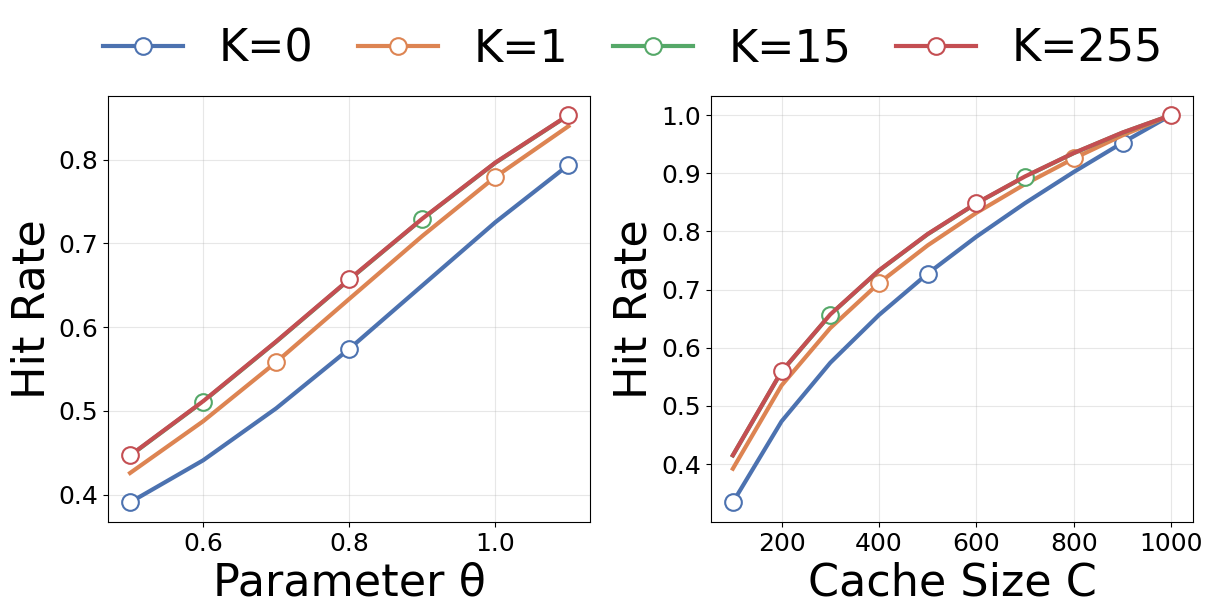

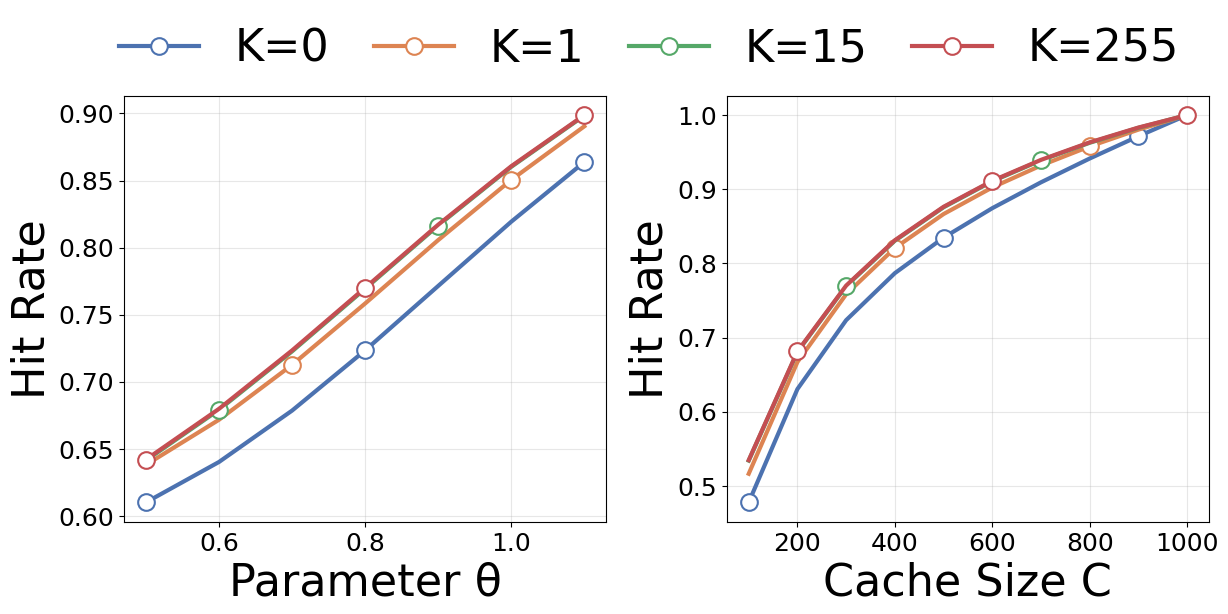

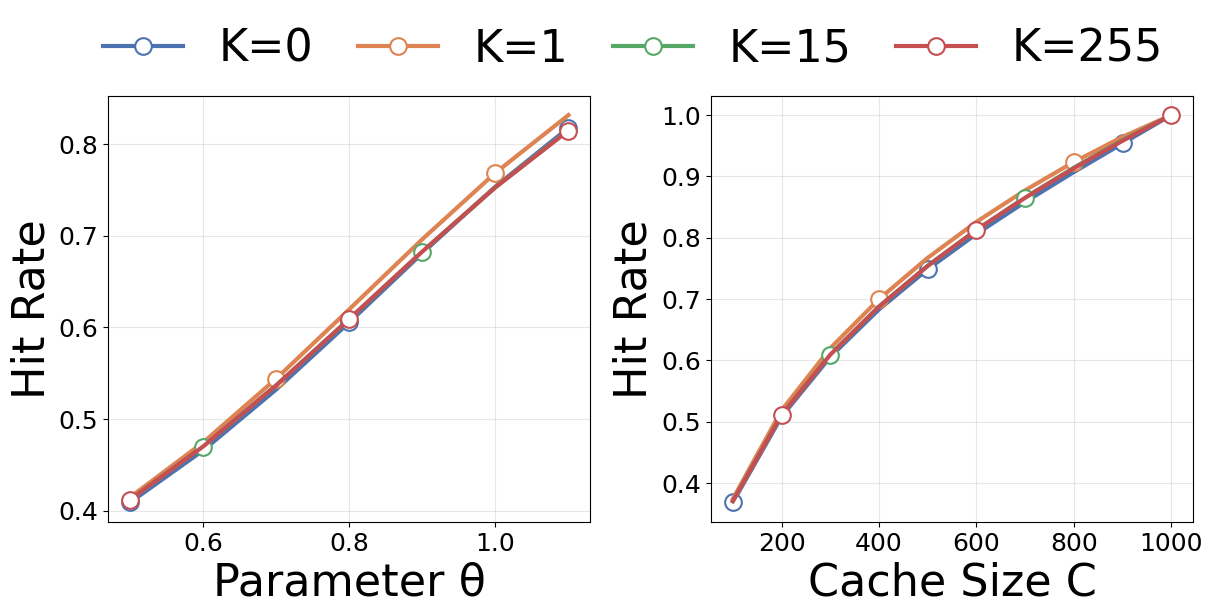

In [ ]:
# np.savez_compressed('data/hr_vs_theta_cache.npz',
#                     hr_vs_theta_irm=hr_vs_theta_irm,
#                     hr_vs_theta_ph=hr_vs_theta_ph,
#                     hr_vs_theta_he=hr_vs_theta_he,
#                     hr_vs_C_irm=hr_vs_C_irm,
#                     hr_vs_C_ph=hr_vs_C_ph,
#                     hr_vs_C_he=hr_vs_C_he)

with np.load('data/hr_vs_theta_cache.npz', allow_pickle=True) as cache:
    def _unwrap(name):
        arr = cache[name]
        return arr.item() if arr.dtype == object and arr.shape == () else arr

    hr_vs_theta_irm = _unwrap('hr_vs_theta_irm')
    hr_vs_theta_ph = _unwrap('hr_vs_theta_ph')
    hr_vs_theta_he = _unwrap('hr_vs_theta_he')
    hr_vs_C_irm = _unwrap('hr_vs_C_irm')
    hr_vs_C_ph = _unwrap('hr_vs_C_ph')
    hr_vs_C_he = _unwrap('hr_vs_C_he')

colors = sns.color_palette("deep", len(ks))

theta_marker_positions = {}
cache_marker_positions = {}
for idx, k in enumerate(ks):
    theta_pos = [i for i in range(len(thetas)) if (i + idx) % 3 == 0]
    cache_pos = [i for i in range(len(cache_sizes)) if (i + idx) % 4 == 0]
    theta_marker_positions[k] = theta_pos or [0]
    cache_marker_positions[k] = cache_pos or [0]


def plot_family(title_prefix, hr_theta, hr_cache, outfile):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    handles = []
    labels = []
    for k, color in zip(ks, colors):
        theta_marks = theta_marker_positions[k]
        cache_marks = cache_marker_positions[k]

        [line] = axes[0].plot(
            thetas,
            hr_theta[k],
            lw=3.0,
            color=color,
            linestyle="-",
            marker="o",
            markersize=12,
            markerfacecolor="white",
            markeredgecolor=color,
            markeredgewidth=1.5,
            markevery=theta_marks,
            label=None,
        )
        axes[1].plot(
            cache_sizes,
            hr_cache[k],
            lw=3.0,
            color=color,
            linestyle="-",
            marker="o",
            markersize=12,
            markerfacecolor="white",
            markeredgecolor=color,
            markeredgewidth=1.5,
            markevery=cache_marks,
            label=None,
        )
        handles.append(line)
        labels.append(f"K={k}")

    axes[0].set_xlabel("Parameter θ", fontsize=32)
    axes[0].set_ylabel("Hit Rate", fontsize=32)
    axes[0].tick_params(axis="both", labelsize=18)
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel("Cache Size C", fontsize=32)
    axes[1].set_ylabel("Hit Rate", fontsize=32)
    axes[1].tick_params(axis="both", labelsize=18)
    axes[1].grid(True, alpha=0.3)

    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1),
        ncol=len(labels),
        fontsize=32,
        frameon=False,
        handlelength=1.8,
        columnspacing=1.0,
    )
    fig.subplots_adjust(top=0.82, wspace=0.25)
    plt.savefig(outfile, bbox_inches='tight', format='pdf')
    plt.show()

plot_family("IRM", hr_vs_theta_irm, hr_vs_C_irm, 'figures/c_k_irm.pdf')
plot_family("PH", hr_vs_theta_ph, hr_vs_C_ph, 'figures/c_k_ph.pdf')
plot_family("HE", hr_vs_theta_he, hr_vs_C_he, 'figures/c_k_he.pdf')

